In [5]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchkbnufft as tkbn
import utils
from recon.TV_FISTA import tvdeblur

# get device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available!")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("CUDA unavailable - using CPU")
    device = torch.device("cpu")

CUDA is available!
GPU: NVIDIA GeForce RTX 2080 Ti
CUDA version: 12.1
Number of GPUs: 4


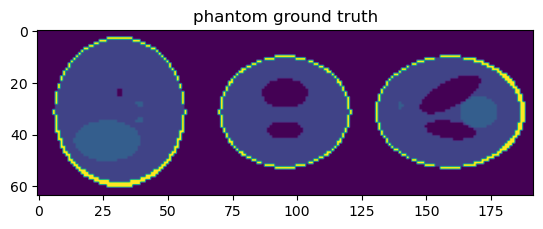

In [6]:
# generate phantom
N = 64
p = utils.phantom.phantom3d((N,N,N)).squeeze().to(device)
p_ortho = utils.view3d.ortho(p)

plt.figure(0)
plt.imshow(np.absolute(p_ortho.cpu().numpy()))
plt.title('phantom ground truth')
plt.show()


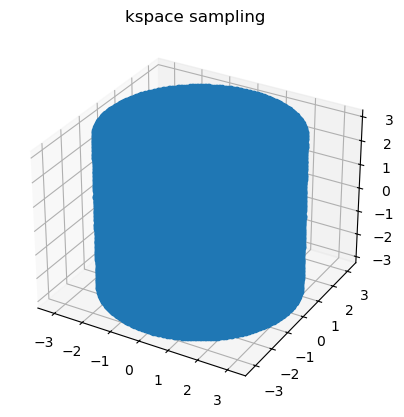

In [7]:
# generate stack of stars kspace trajectory
kspoke = np.stack((np.linspace(-np.pi,np.pi,N),np.zeros((N))),axis=0)
nspokes = int(np.pi*N) # fully sampled in-plane is pi*N
nzenc = 16 # N = fully sampled

# loop through spokes
for i in range(0,nspokes):
    theta = np.pi*i/nspokes
    R = [[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]]
    kspokei = np.matmul(R,kspoke)
    if i == 0:
        klocs2d = kspokei
    else:
        klocs2d = np.concatenate((klocs2d,kspokei),axis=1)

# loop through kz encodes
kzs = np.linspace(-np.pi,np.pi,nzenc)
for i in range(0,nzenc):
    kzenci = np.concatenate((klocs2d,kzs[i]*np.ones((1,N*nspokes))),0)
    if i == 0:
        klocs3d = kzenci
    else:
        klocs3d = np.concatenate((klocs3d,kzenci),1)
klocs = klocs3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(klocs[0,:],klocs[1,:],klocs[2,:],'.')
plt.title('kspace sampling')
plt.show()

klocs = torch.tensor(klocs).to(device)

/home/djfrey/tvrec/utils/phantom.py:97: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(smaps,dtype=torch.complex128)


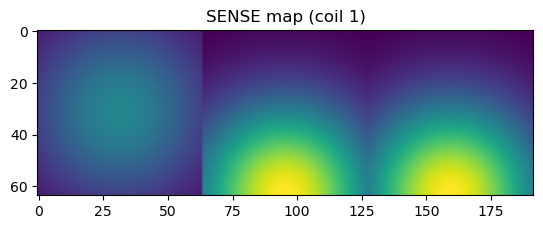

In [4]:
# create the nufft object and define fwd/adj operators
nufft_ob = tkbn.KbNufft(im_size=(N,N,N),device=device)
adjnufft_ob = tkbn.KbNufftAdjoint(im_size=(N,N,N),device=device)

smaps = utils.phantom.simsmaps((N,N,N)).squeeze().to(device)

def A_fwd(x):
    return nufft_ob(x.unsqueeze(0).unsqueeze(0),klocs,smaps=smaps.unsqueeze(0))
def A_adj(b):
    return adjnufft_ob(b,klocs,smaps=smaps.unsqueeze(0)).clone().squeeze()

smaps_ortho = utils.view3d.ortho(smaps[1,:,:,:].squeeze())

plt.figure(0)
plt.imshow(np.absolute(smaps_ortho.cpu().numpy()))
plt.title('SENSE map (coil 1)')
plt.show()